# Theorem 4 Validation
### Validate that the Attention Mechanism enables MIL to learn about Bags in Bag Domain Spaces that are PAC Learnable
- If a bag consisting of MNIST images has 1 equal to 3, then the bag is a Positive
- If each image is not together, label the bag as Negative
- Non-Attention MIL utilizes mi-Net and MI-Net, which are representative methodologies.
- Attention MIL uses Attention Mean Pooling, Additive Pooling, and Conjunctive Pooling, which are representative methodologies.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 516kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Bag shapes: torch.Size([2048, 10, 1, 28, 28])
Bag labels: torch.Size([2048, 1])


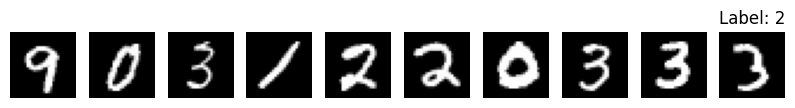

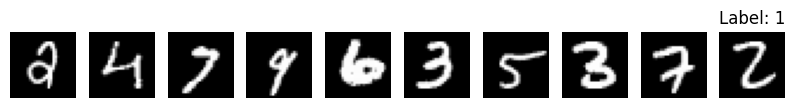

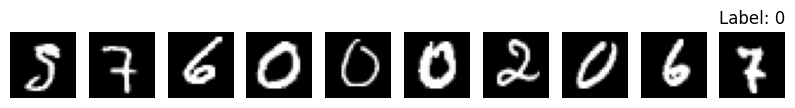

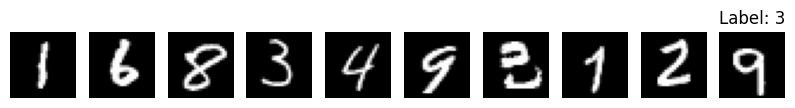

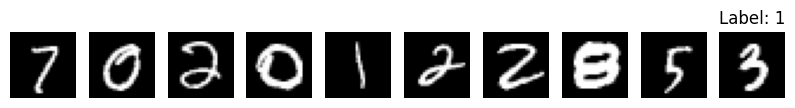

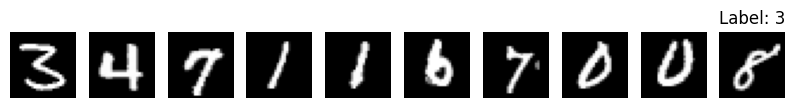

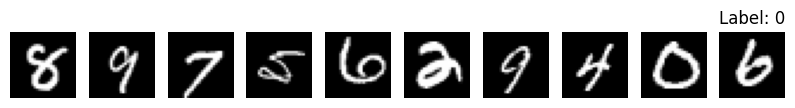

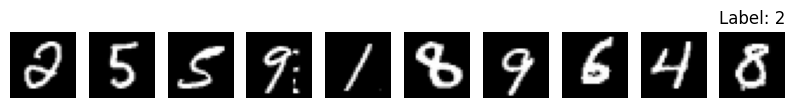

In [1]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

class MNISTBagDataset(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform
        self.num_instances = len(mnist_dataset)

    def __len__(self):
        return self.num_instances

    def __getitem__(self, index):
        # Randomly create a bag.
        bag_images = []
        bag_contains_1 = 0
        bag_contains_3 = 0
        bag_contains_5 = 0
        bag_contains_7 = 0

        # Randomly select image indices.
        instance_indices = torch.randint(0, self.num_instances, (10,))
        labels = []

        for idx in instance_indices:
            image, label = self.mnist_dataset[idx]

            # Label the bag as Positive if it contains images with labels 1 or 3.
            if label == 1:
                bag_contains_1 += 1
            elif label == 3:
                bag_contains_3 += 1
            elif label == 5:
                bag_contains_5 += 1
            elif label == 7:
                bag_contains_7 += 1

            if self.transform:
                image = self.transform(image)

            bag_images.append(image)
            labels.append(label)

        bag_images = torch.stack(bag_images)

        # Label the bag as Positive if it contains both 1 and 3.
        if (bag_contains_3 > 0) and (bag_contains_5 > 0):
            if bag_contains_7 == 0 and (bag_contains_1 > bag_contains_3):
                bag_label = torch.tensor([2], dtype=torch.float32)

            if bag_contains_1 > 0 and (bag_contains_7 > bag_contains_3):
                bag_label = torch.tensor([3], dtype=torch.float32)

            else:
                bag_label = torch.tensor([1], dtype=torch.float32)

        elif (bag_contains_7 != 0) and (bag_contains_1 > 0):
            bag_label = torch.tensor([3], dtype=torch.float32)

        elif bag_contains_1 > 0:
            bag_label = torch.tensor([2], dtype=torch.float32)

        else:
            bag_label = torch.tensor([0], dtype=torch.float32)

        return bag_images, bag_label

# Load the MNIST dataset.
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

# Get the size of the entire dataset.
dataset_size = len(mnist_train)

# Calculate the size to split into Train and Test datasets.
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Create indices to split the dataset.
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Split indices into Train and Test datasets.
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use the Subset class to create Train and Test datasets.
train_dataset = Subset(mnist_train, train_indices)
test_dataset = Subset(mnist_train, test_indices)

# Create a MIL-style dataset.
train_dataset = MNISTBagDataset(train_dataset, transform=None)
test_dataset = MNISTBagDataset(test_dataset, transform=None)

# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def show_images(images, label):
    # Create a canvas to draw images.
    fig = plt.figure(figsize=(10, 1))
    for idx in range(len(images)):
        ax = fig.add_subplot(1, len(images), idx + 1)
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.axis('off')
    plt.title("Label: " + str(label))
    plt.show()

# Check the dataset
for bags, labels in train_loader:
    print('Bag shapes:', bags.shape)
    print('Bag labels:', labels.shape)
    break

for i in range(8):
    show_images(bags[i], int(labels[i].detach().cpu().numpy()[0]))

# Testset

In [2]:
import random
test_dataset = Subset(mnist_train, test_indices)

numbers = []
for i in range(0, 11):
    for j in range(len(test_dataset)):
        if i == test_dataset[j][1]:
            numbers.append(test_dataset[j][0])
            break

numbers = np.array(numbers)

normal_testset1 = []

for i in range(50):
    temp_set = []
    for j in range(10):
        r = random.randint(0, 9)
        if r == 1 or r == 3 or r == 5 or r == 7:
            while True:
                r = random.randint(0, 9)
                if r == 1 or r == 3 or r == 5 or r == 7:
                    continue
                else:
                    break
        temp_set.append(numbers[r])
    normal_testset1.append(temp_set)

normal_testset1 = np.array(normal_testset1)

normal_testset3 = []

for i in range(50):
    temp_set = []
    for j in range(1):
        temp_set.append(numbers[3])

    for j in range(9):
        r = random.randint(0, 9)
        if r == 1 or r == 7:
            while True:
                r = random.randint(0, 9)
                if r == 1 or r == 7:
                    continue
                else:
                    break
        temp_set.append(numbers[r])
    normal_testset3.append(temp_set)

normal_testset3 = np.array(normal_testset3)

normal_testset4 = []

for i in range(50):
    temp_set = []
    for j in range(1):
        temp_set.append(numbers[5])

    for j in range(9):
        r = random.randint(0, 9)
        if r == 3 or r == 7:
            while True:
                r = random.randint(0, 9)
                if r == 3 or r == 7:
                    continue
                else:
                    break
        temp_set.append(numbers[r])
    normal_testset4.append(temp_set)

normal_testset4 = np.array(normal_testset4)

abnormal_testset1 = []

for i in range(50):
    temp_set = []
    temp_set.append(numbers[7])
    temp_set.append(numbers[3])
    temp_set.append(numbers[5])

    for j in range(7):
        r = random.randint(0, 9)
        temp_set.append(numbers[r])
    abnormal_testset1.append(temp_set)

abnormal_testset1 = np.array(abnormal_testset1)

abnormal_testset2 = []

for i in range(50):
    temp_set = []
    for j in range(1):
        temp_set.append(numbers[1])

    for j in range(9):
        r = random.randint(0, 9)
        if r== 3 or r == 5 or r == 7:
            while True:
                r = random.randint(0, 9)
                if r== 3 or r == 5 or r == 7:
                    continue
                else:
                    break
        temp_set.append(numbers[r])
    abnormal_testset2.append(temp_set)

abnormal_testset2 = np.array(abnormal_testset2)

testset_np = np.concatenate([
    normal_testset1,
    normal_testset3,
    normal_testset4,
    abnormal_testset1,
    abnormal_testset2
])

test_label = np.array([[0] for i in range(150)] + [[1] for i in range(50)] + [[2] for i in range(50)])

class torchDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.x_data.shape[0]

testset = torchDataset(testset_np, test_label)

test_dataloader = DataLoader(testset, batch_size=64, shuffle=False)

# Models

In [3]:
# Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return x

class miNet_mean(torch.nn.Module):
    def __init__(self):
        super(miNet_mean, self).__init__()
        self.encoder = Encoder()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        predicts = []
        for i in range(10):
            predicts.append(self.classifier(
                self.encoder(x[:, i]).reshape(x.shape[0], 1, -1)
            ))
        predicts = torch.concat(predicts, 1)

        return predicts.mean(1)

class miNet_max(torch.nn.Module):
    def __init__(self):
        super(miNet_max, self).__init__()
        self.encoder = Encoder()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        predicts = []
        for i in range(10):
            predicts.append(self.classifier(
                self.encoder(x[:, i]).reshape(x.shape[0], 1, -1)
            ))
        predicts = torch.concat(predicts, 1)

        return predicts.max(1)[0]

class AttentionMIL(torch.nn.Module):
    def __init__(self):
        super(AttentionMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A, dim=1)  # softmax over K
        features = A*features
        features = features.mean(1)

        return self.classifier(features)

class AdditiveMIL(torch.nn.Module):
    def __init__(self):
        super(AdditiveMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A, dim=1)  # softmax over K
        features = A*features
        predicts = self.classifier(features)

        return torch.functional.F.log_softmax(torch.sum(predicts, 1), dim=1)


class ConjunctiveMIL(torch.nn.Module):
    def __init__(self):
        super(ConjunctiveMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A, dim=1)  # softmax over K
        predicts = A*self.classifier(features)

        return torch.functional.F.log_softmax(torch.sum(predicts, 1), dim=1)

# Test

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConjunctiveMIL().to(device)

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
for epoch in tqdm_notebook(range(20)):
    train_pred, train_label = [], []
    for data in tqdm_notebook(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1).long())
        loss.backward()
        optimizer.step()
        train_pred += list(outputs.detach().cpu().numpy())
        train_label += list(labels.detach().cpu().numpy())
    train_pred = np.array(train_pred)
    train_label = np.array(train_label)

    print(f'Epoch: {epoch}')
    print(f'acc Score: {accuracy_score(train_label, train_pred.argmax(1))}')
    print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="macro")}')
    print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="micro")}')
    print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="weighted")}')

model.eval()
test_pred, test_label = [], []
for data in tqdm_notebook(test_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    test_pred += list(outputs.detach().cpu().numpy())
    test_label += list(labels.detach().cpu().numpy())

test_pred = np.array(test_pred)
test_label = np.array(test_label)

print(f'acc Score: {accuracy_score(test_label, test_pred.argmax(1))}')
print(f'F1 Score: {f1_score(test_label, test_pred.argmax(1), average="macro")}')
print(f'F1 Score: {f1_score(test_label, test_pred.argmax(1), average="micro")}')
print(f'F1 Score: {f1_score(test_label, test_pred.argmax(1), average="weighted")}')
